In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, EstimatorV2, EstimatorOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import ising_disorder_circuit as circuits
import matplotlib.pyplot as plt
#from cobos.token import ibm_token
from utils import hexec
import numpy as np
import itertools

plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=28, weight="bold")

## Credentials

In [2]:
service = QiskitRuntimeService()

## RESULTS 1

## Device selection

> (Joana): I am using Nazca since the queue is shorter, but note that Nazca has a large EPLG.

In [3]:
#device = "ibm_nazca"
device = "ibm_sherbrooke"
optimization_level = 3
backend = service.backend(device)

## Layout

> (Joana): We can obtain the best 100q chain from backend properties. I will use this for the qubit indices instead of checking manually.

In [4]:
lf100 = backend.properties().general_qlists 
qubits_inds = lf100[0]['qubits']
print(qubits_inds)

[57, 58, 71, 77, 76, 75, 90, 94, 95, 96, 109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 112, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 91, 79, 80, 81, 72, 62, 61, 60, 53, 41, 40, 39, 33, 20, 19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 48, 47, 35, 28, 27, 26, 25, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73, 85, 86, 87, 88, 89, 74, 70, 69, 68]


### Parameters

In [5]:
seed = 0
disorder_parameter = 0.3
nqubits_arr = 2**np.arange(2, 7)
twoqdepth_arr = 2**np.arange(2, 7)
params_arr = list(itertools.product(nqubits_arr, twoqdepth_arr))

### Circuits

In [6]:
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = []
for i, nqubits in enumerate(nqubits_arr):
    pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubits_inds[:nqubits])
    for j, twoqdepth in enumerate(twoqdepth_arr):
        physical_circuits_arr.append(pm.run(logical_circuits_arr[i*len(twoqdepth_arr)+j]))

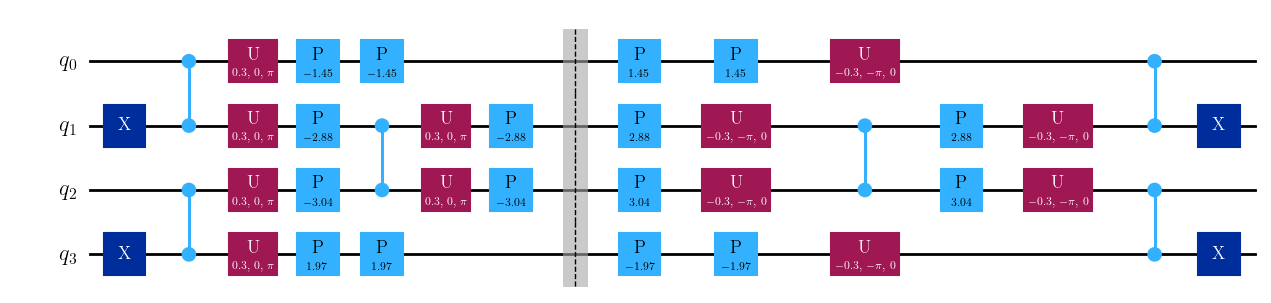

In [11]:
logical_circuits_arr[0].draw(output="mpl", fold=-1)

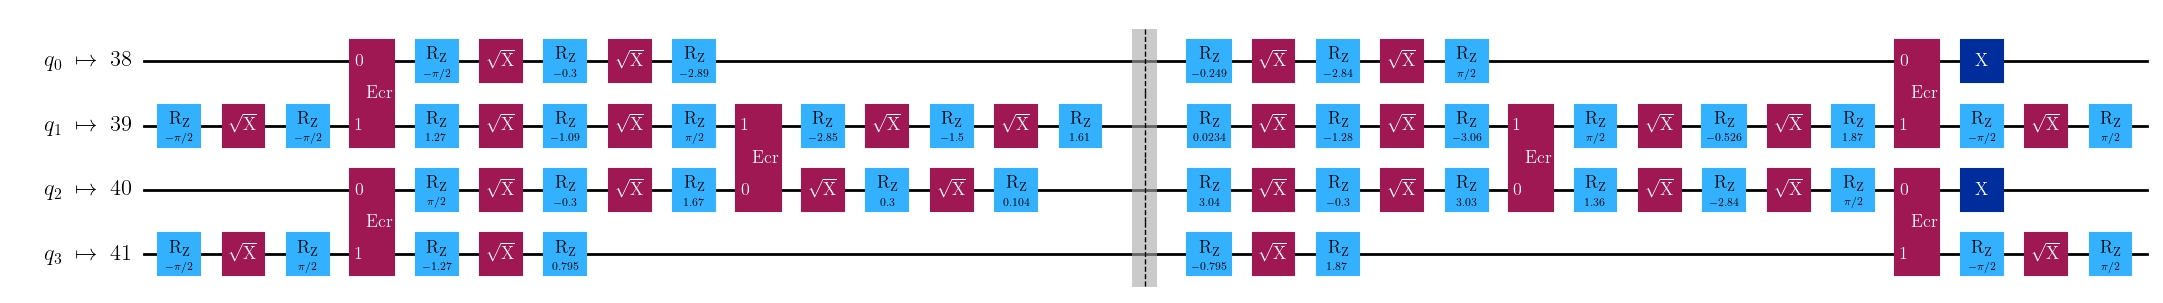

In [12]:
physical_circuits_arr[0].draw(output="mpl", fold=-1, idle_wires=False)

## Circuit execution

> (Joana): For large circuits in Nazca (large EPLG), noise factor of 5 is failing. Runtime error: "The circuit with 1008 2-qubit gates at noise factor 5.0 exceeds the system limits by 0.8%." -> You will see some entries with a 100% error. This is a consequence of gate folding for noise amplification, and it can be solved by considering smaller noise factors (see comment below).


In [7]:
default_shots = 10000
optimization_level = 0 # Deactivate error suppression
resilience_level = 0 # Deactivate error mitigation
execution_database = "single_run_experiments.json"
zne_mitigation = "none"
measure_mitigation = True
dynamical_decoupling = True
twirling = True
run = 1

zne_mitigation_dict = {"none": "",
                       "linear": r"linear",
                       "quadratic": r'polynomial_degree_2',
                       "exponential": r"exponential"}

estimator_options = {
    "default_shots": default_shots,
    "optimization_level": optimization_level,
    "resilience_level": resilience_level,
    "dynamical_decoupling": {
        "enable": dynamical_decoupling,
        "sequence_type": "XY4"
    },
    "resilience": {
        "zne_mitigation": bool(zne_mitigation_dict[zne_mitigation]),
        "measure_mitigation": measure_mitigation
    },
    "twirling": {
        "enable_gates": twirling,
        "enable_measure": measure_mitigation
    }
}

if bool(zne_mitigation_dict[zne_mitigation]):
    estimator_options["resilience"]["zne"] = {"extrapolator": zne_mitigation_dict[zne_mitigation]}
    #estimator_options["resilience"]["zne"] = {"noise_factors": (1, 2, 3)} 

job_db = hexec.ExecDB(execution_database)

In [14]:
# Remote execution
job_db.execute_estimator_batch(backend, estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op)

# Load results
jobs = job_db.search_by_params(estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op, limit=1)
jobs_ids = [job["job_id"] for job in jobs["jobs"]]
jobs_nqubits = np.array([job["nqubits"] for job in jobs["jobs"]])
jobs_depth = np.array([job["depth"] for job in jobs["jobs"]])
np.save(f'{device}_job_ids_linear.npy',jobs_ids)

In [9]:
# Load results
jobs_ids = np.load(f'{device}_job_ids_linear.npy')

jobs_obj = [service.job(job_id=job_id) for job_id in jobs_ids]
errors_list = []
for job in jobs_obj:
    try:
        error = (1-float(job.result()[0].data.evs))*100 
    except:
        error = 100
    errors_list.append(error)
errors = np.array(errors_list).reshape((len(nqubits_arr), len(twoqdepth_arr)))

/var/folders/_p/xh5ytd5n055_jnqwqg4n0cjm0000gn/T/ipykernel_11400/3145253300.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = (1-float(job.result()[0].data.evs))*100


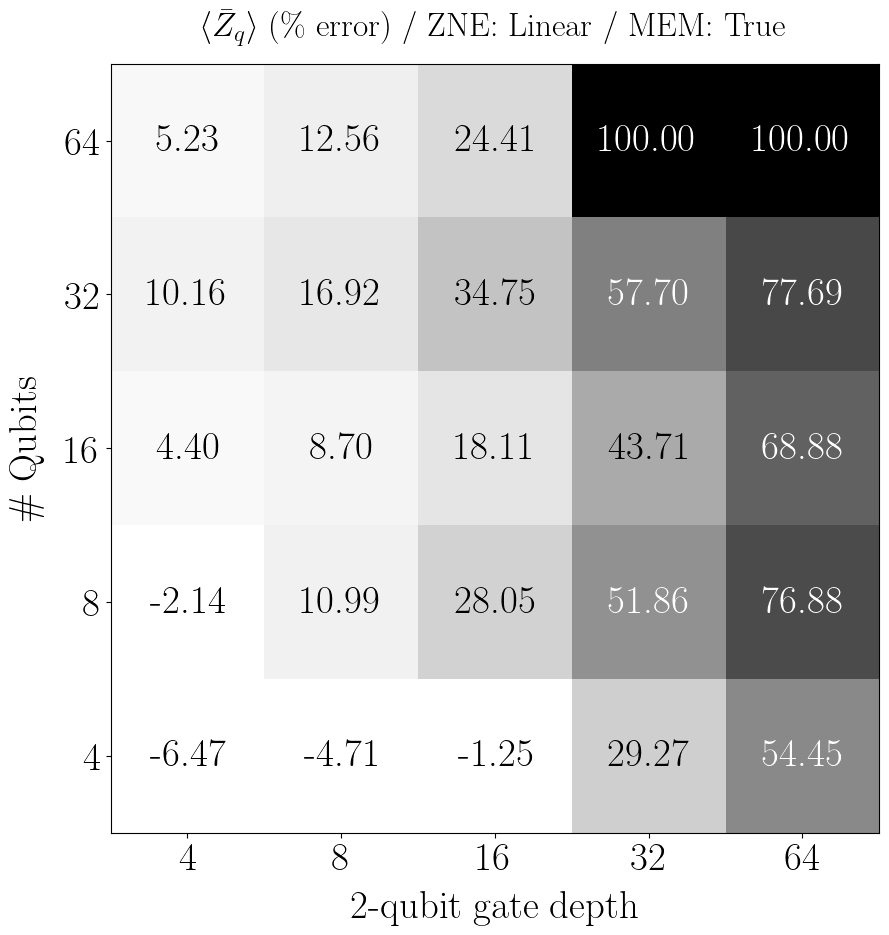

In [11]:
# Linear ZNE
fig, ax = plt.subplots(figsize=[10, 10])
plt.imshow(errors[::-1, :], cmap="Greys", vmin=0, vmax=100)
for i, error in enumerate(errors[::-1].flatten()):
    plt.text(i % errors.shape[0] if errors.shape[0] > 1 else i, i // errors.shape[1], f"{error:.02f}", horizontalalignment="center", verticalalignment="center", color="black" if error < 50 else "white")
plt.xticks(np.arange(errors.shape[1]), twoqdepth_arr)
plt.yticks(np.arange(errors.shape[0]), nqubits_arr[::-1])
plt.xlabel(r"2-qubit gate depth", labelpad=10)
plt.ylabel(r"\# Qubits", labelpad=15)
plt.title(r"$\langle \bar{Z}_q \rangle$  (\% error) / " f"ZNE: {zne_mitigation.title()} / MEM: {measure_mitigation}", pad = 20, fontdict={"size":24})
plt.tight_layout()

# VARIATIONS (Joana)

We see that, for large depth, the errors are larger for small system sizes, contrarily to what is expected. Let's try different variations to correct for that:

## 1. Check transpilation using optimization level

> Joana: Depending on the device, automatic transpilation won't do a good job for very short qubit chains (4/8 qubits). Short qubit chains are also more unstable, since the effect of errors on one qubit is larger. This is done with ibm_sheerbroke and the results seem quite consistent.

In [8]:
optimization_level = 3
pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = [pm.run(circuit) for circuit in logical_circuits_arr]

> (Joana): The function below is useful to check the mapping.

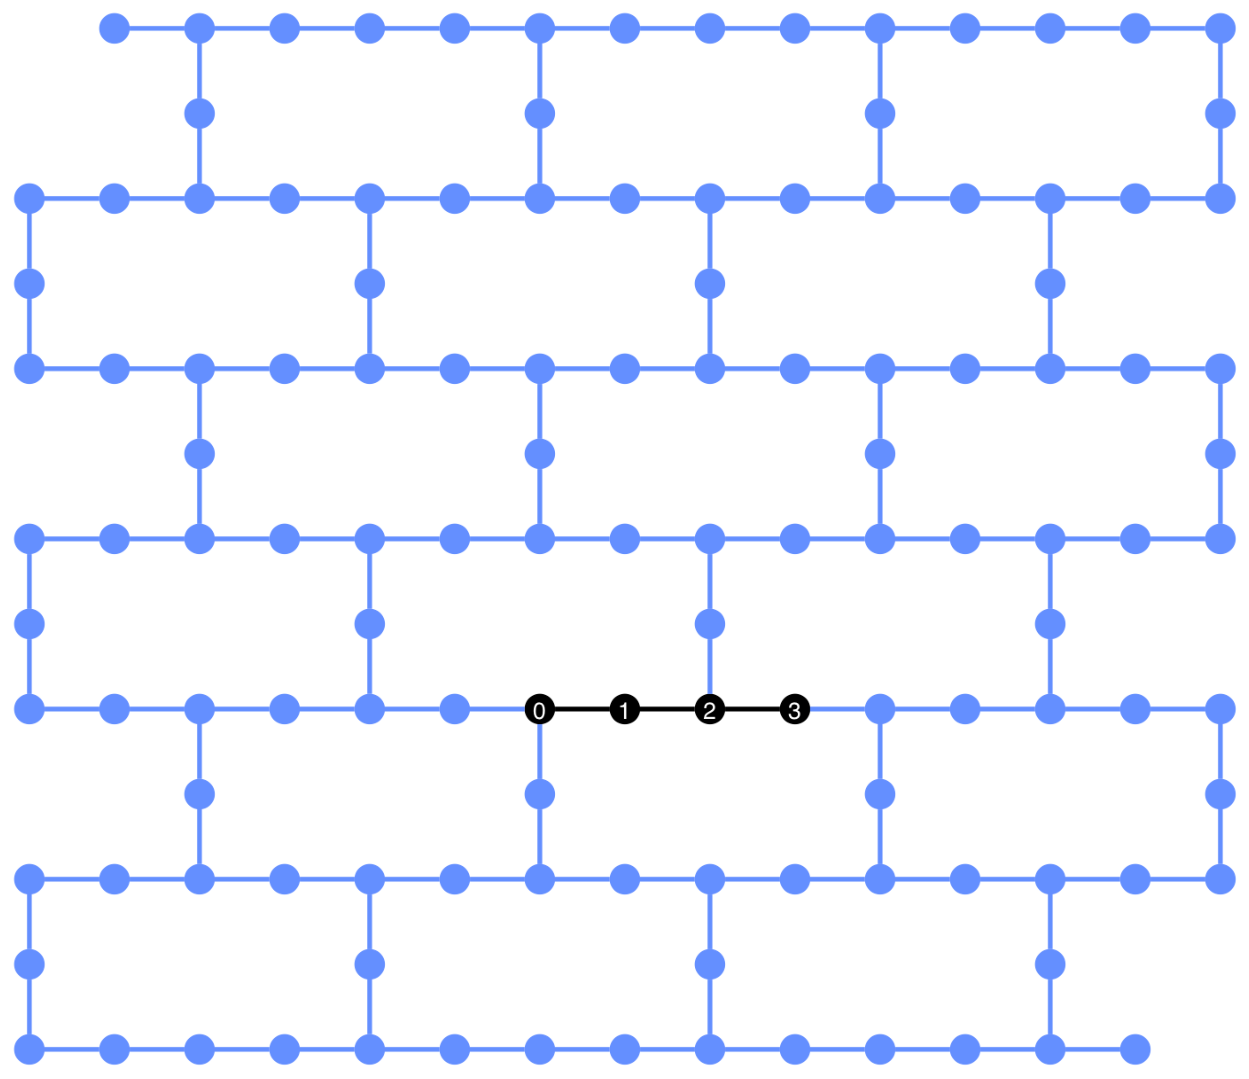

In [15]:
from qiskit.visualization import plot_circuit_layout
circuit_index = 0
plot_circuit_layout(physical_circuits_arr[circuit_index], backend) #this can be used to visualize the layout

In [13]:
# Remote execution
job_db.execute_estimator_batch(backend, estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op)

# Load results
jobs = job_db.search_by_params(estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op, limit=1)
jobs_ids = [job["job_id"] for job in jobs["jobs"]]
jobs_nqubits = np.array([job["nqubits"] for job in jobs["jobs"]])
jobs_depth = np.array([job["depth"] for job in jobs["jobs"]])
np.save(f'{device}_job_ids_optimized.npy',jobs_ids)

/var/folders/_p/xh5ytd5n055_jnqwqg4n0cjm0000gn/T/ipykernel_80432/3985920450.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = (1-float(job.result()[0].data.evs))*100


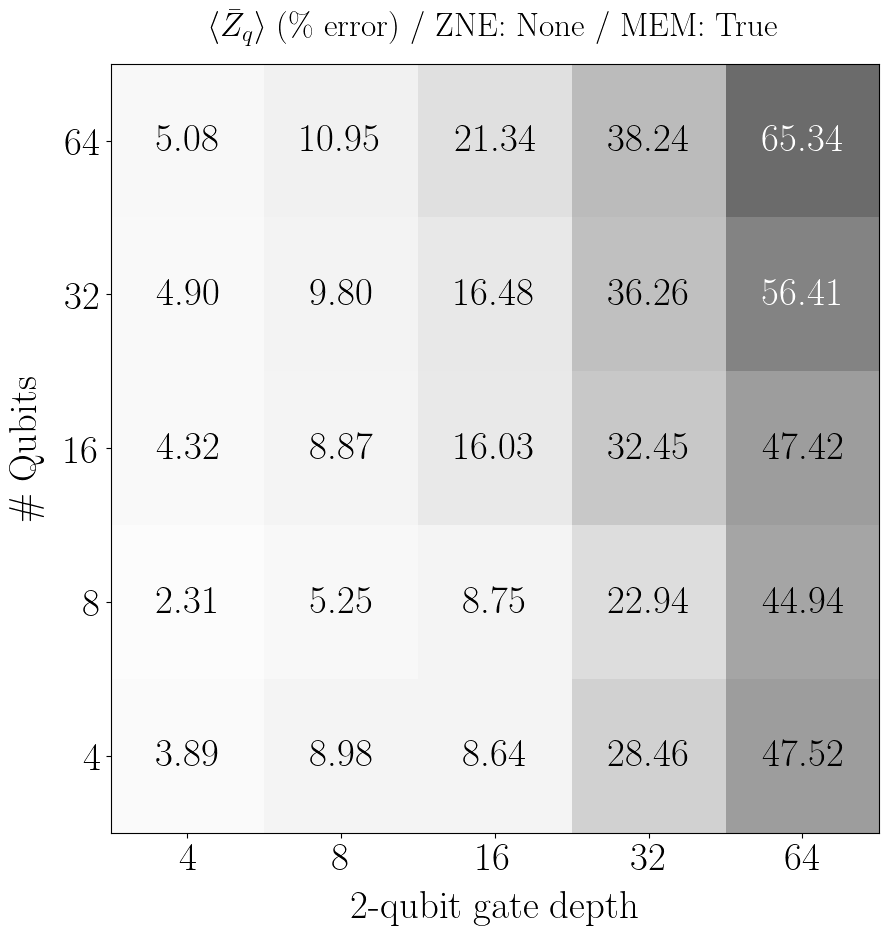

In [14]:
jobs_ids = np.load(f'{device}_job_ids_optimized.npy')
jobs_obj = [service.job(job_id=job_id) for job_id in jobs_ids]
errors_list = []
for job in jobs_obj:
    try:
        error = (1-float(job.result()[0].data.evs))*100 
    except:
        error = 100
    errors_list.append(error)
errors = np.array(errors_list).reshape((len(nqubits_arr), len(twoqdepth_arr)))

fig, ax = plt.subplots(figsize=[10, 10])
plt.imshow(errors[::-1, :], cmap="Greys", vmin=0, vmax=100)
for i, error in enumerate(errors[::-1].flatten()):
    plt.text(i % errors.shape[0] if errors.shape[0] > 1 else i, i // errors.shape[1], f"{error:.02f}", horizontalalignment="center", verticalalignment="center", color="black" if error < 50 else "white")
plt.xticks(np.arange(errors.shape[1]), twoqdepth_arr)
plt.yticks(np.arange(errors.shape[0]), nqubits_arr[::-1])
plt.xlabel(r"2-qubit gate depth", labelpad=10)
plt.ylabel(r"\# Qubits", labelpad=15)
plt.title(r"$\langle \bar{Z}_q \rangle$  (\% error) / " f"ZNE: {zne_mitigation.title()} / MEM: {measure_mitigation}", pad = 20, fontdict={"size":24})
plt.tight_layout()

## 2. Plot single qubit results to see qubit-wise errors

> (Joana): The observable as an average of expectation values of $Z_i$ is much more affected by outliers for short qubit chains. In certain cases, it is interesting to plot a qubit-wise output. Here I adapted the code to get the list of observables, so I am not using hexec.py.

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def single_pauliz_op(nqubits):

    #redefine observable as a list of observables 
    logical_observables = [SparsePauliOp('I'*i + 'Z' + 'I'*(nqubits-i-1)) for i in range(nqubits)]

    return logical_observables

logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
logical_observables_arr = [single_pauliz_op(nqubits) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = []
physical_observables_arr = []

lf100 = backend.properties().general_qlists
chain_100q_inds = lf100[0]['qubits'][::-1]

#not using hexec.py so I need to transpile the observables as well
for logical_circuit, logical_observable in zip(logical_circuits_arr, logical_observables_arr):

    pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=chain_100q_inds[:logical_circuit.num_qubits]) #here I am taking a very simple fixed layout
    physical_circuit = pm.run(logical_circuit)
    physical_circuits_arr.append(physical_circuit)

    physical_layout = physical_circuit.layout
    physical_observable = [op.apply_layout(physical_layout) for op in logical_observable]
    physical_observables_arr.append(physical_observable)

jobs = []
job_ids = []

with Batch(backend=backend) as batch:

    estimator = EstimatorV2(session=batch, options=estimator_options)

    for physical_circuit, physical_observable in zip(physical_circuits_arr, physical_observables_arr):

        pub = (physical_circuit, physical_observable)
        job = estimator.run([pub])
        jobs.append(job)
        job_ids.append(job.job_id())
        #print(f"  - {job.job_id()}")

        np.save('job_ids_layout.npy', job_ids)

### Code to plot qubit-wise errors on the backend

> (Joana): feel free to adapt the code to your needs and add a color bar!

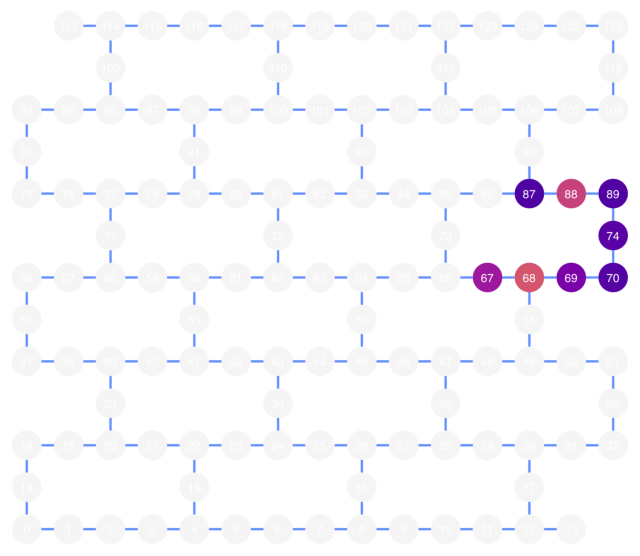

In [20]:
from qiskit.visualization import plot_gate_map
import matplotlib as mpl

nqubits = 8
twoqdepth = 32
index = list(nqubits_arr).index(nqubits)*len(twoqdepth_arr)+list(twoqdepth_arr).index(twoqdepth)

circuit = jobs_obj[index].inputs['pubs'][0][0] #Retrieve the isa circuit from the job to get the layout!
result = jobs_obj[index].result()[0]
 
qubit_expval_map = {}
for qubit in range(backend.num_qubits):
    if qubit not in circuit.layout.final_index_layout():
        qubit_expval_map[qubit] = float(-1)
    else:
        qubit_expval_map[qubit] = result.data.evs[circuit.layout.final_index_layout().index(qubit)]

cmap = plt.get_cmap('plasma_r')

qubit_color = []
for exp_val in qubit_expval_map.values():
    if exp_val == -1:
        qubit_color.append('#F5F5F5')
    else:
        color_html = mpl.colors.rgb2hex(cmap(exp_val))
        qubit_color.append(color_html)
        
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))

## 3. Interaction strength for the MBL circuit affects how noise propagates

The width of the light cone affects the propagation of errors. We also need to take into account the depth and the size of the circuit. 

> (Joana) : What you call disorder parameter here is in fact the interaction strength of the MBL circuit!

In [10]:
seed = 0
disorder_parameter = 0.05 # small disorder parameter, errors propagate slower

optimization_level = 3
pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = [pm.run(circuit) for circuit in logical_circuits_arr]

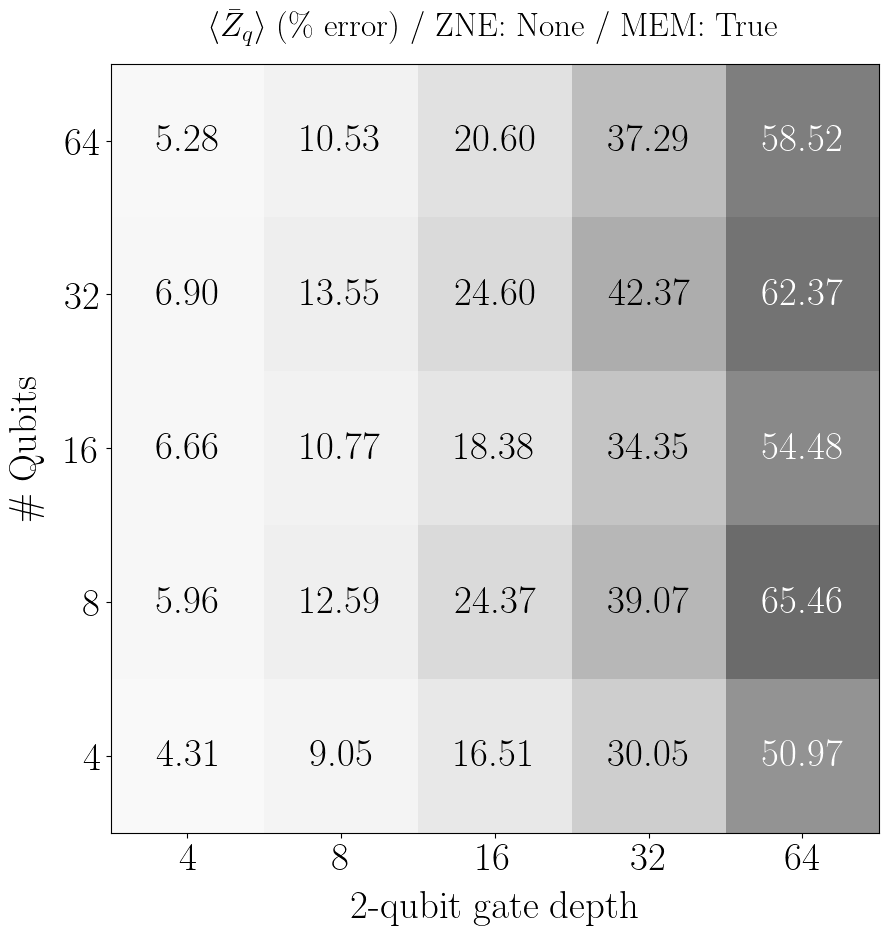

In [11]:
# Remote execution
job_db.execute_estimator_batch(backend, estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op)

# Load results
jobs = job_db.search_by_params(estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op, limit=1)
jobs_ids = [job["job_id"] for job in jobs["jobs"]]
jobs_nqubits = np.array([job["nqubits"] for job in jobs["jobs"]])
jobs_depth = np.array([job["depth"] for job in jobs["jobs"]])
jobs_obj = [service.job(job_id=job_id) for job_id in jobs_ids]
errors = np.array([(1-float(np.mean(job.result()[0].data.evs)))*100 for job in jobs_obj]).reshape((len(nqubits_arr), len(twoqdepth_arr)))

fig, ax = plt.subplots(figsize=[10, 10])
plt.imshow(errors[::-1, :], cmap="Greys", vmin=0, vmax=100)
for i, error in enumerate(errors[::-1].flatten()):
    plt.text(i % errors.shape[0] if errors.shape[0] > 1 else i, i // errors.shape[1], f"{error:.02f}", horizontalalignment="center", verticalalignment="center", color="black" if error < 50 else "white")
plt.xticks(np.arange(errors.shape[1]), twoqdepth_arr)
plt.yticks(np.arange(errors.shape[0]), nqubits_arr[::-1])
plt.xlabel(r"2-qubit gate depth", labelpad=10)
plt.ylabel(r"\# Qubits", labelpad=15)
plt.title(r"$\langle \bar{Z}_q \rangle$  (\% error) / " f"ZNE: {zne_mitigation.title()} / MEM: {measure_mitigation}", pad = 20, fontdict={"size":24})
plt.tight_layout()

In [12]:
seed = 0
disorder_parameter = 0.5 # large disorder parameter, errors propagate faster

optimization_level = 3
pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)
logical_circuits_arr = [circuits.cunc_example_circuit(nqubits, twoqdepth, seed, disorder_parameter) for nqubits, twoqdepth in params_arr]
physical_circuits_arr = [pm.run(circuit) for circuit in logical_circuits_arr]

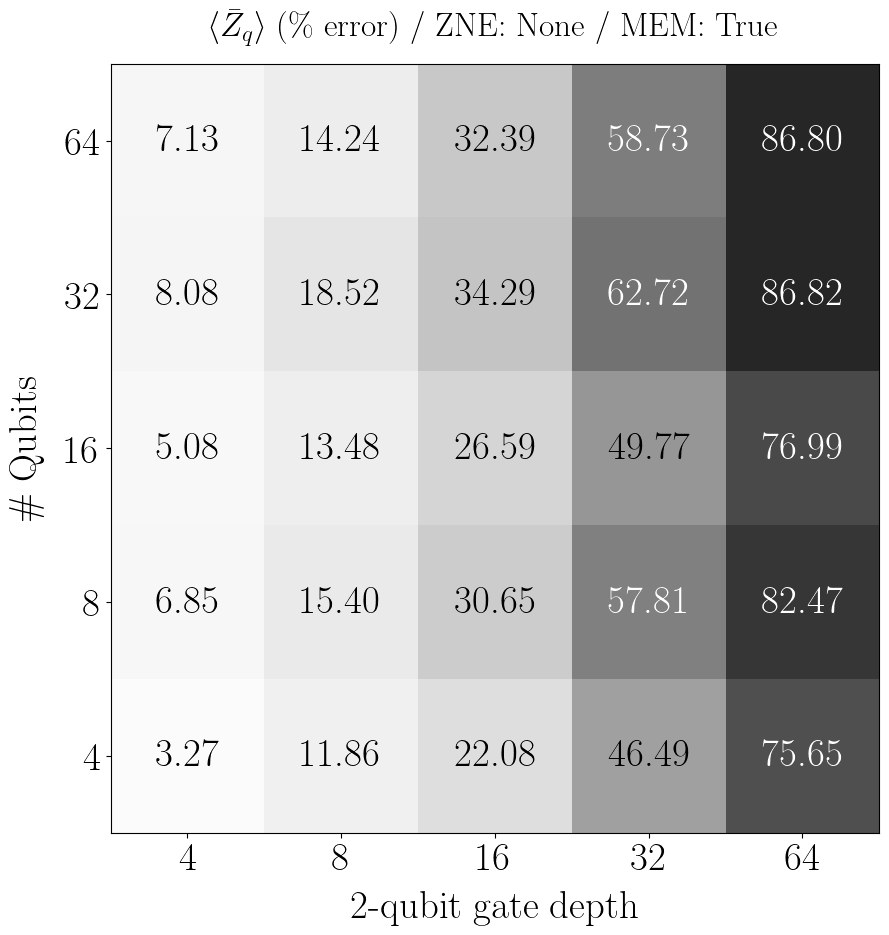

In [13]:
# Remote execution
job_db.execute_estimator_batch(backend, estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op)

# Load results
jobs = job_db.search_by_params(estimator_options, physical_circuits_arr, circuits.single_pauliz_average_op, limit=1)
jobs_ids = [job["job_id"] for job in jobs["jobs"]]
jobs_nqubits = np.array([job["nqubits"] for job in jobs["jobs"]])
jobs_depth = np.array([job["depth"] for job in jobs["jobs"]])
jobs_obj = [service.job(job_id=job_id) for job_id in jobs_ids]
errors = np.array([(1-float(np.mean(job.result()[0].data.evs)))*100 for job in jobs_obj]).reshape((len(nqubits_arr), len(twoqdepth_arr)))

fig, ax = plt.subplots(figsize=[10, 10])
plt.imshow(errors[::-1, :], cmap="Greys", vmin=0, vmax=100)
for i, error in enumerate(errors[::-1].flatten()):
    plt.text(i % errors.shape[0] if errors.shape[0] > 1 else i, i // errors.shape[1], f"{error:.02f}", horizontalalignment="center", verticalalignment="center", color="black" if error < 50 else "white")
plt.xticks(np.arange(errors.shape[1]), twoqdepth_arr)
plt.yticks(np.arange(errors.shape[0]), nqubits_arr[::-1])
plt.xlabel(r"2-qubit gate depth", labelpad=10)
plt.ylabel(r"\# Qubits", labelpad=15)
plt.title(r"$\langle \bar{Z}_q \rangle$  (\% error) / " f"ZNE: {zne_mitigation.title()} / MEM: {measure_mitigation}", pad = 20, fontdict={"size":24})
plt.tight_layout()